In [1]:
import spacy
nlp = spacy.load("en_core_web_sm")
print("spaCy works!")

spaCy works!


In [8]:
import pandas as pd

# Load both files
df_fake = pd.read_csv("Fake.csv.zip")
df_true = pd.read_csv("True.csv.zip")

# Add labels
df_fake["label"] = "FAKE"
df_true["label"] = "REAL"

# Combine the datasets
df = pd.concat([df_fake, df_true], ignore_index=True)

# Normalize column names
df.columns = [c.lower().strip() for c in df.columns]

# Ensure required columns exist
for col in ["title", "text", "label"]:
    if col not in df.columns:
        df[col] = ""

# Keep only needed columns
df = df[["title", "text", "label"]].copy()

# Fix missing values
df["title"] = df["title"].fillna("")
df["text"] = df["text"].fillna("")
df["label"] = df["label"].fillna("").str.upper()

# Save unified dataset
df.to_csv("fake_or_real_news.csv", index=False)

print("Merged dataset saved as fake_or_real_news.csv")
print("Total rows:", len(df))
df.head()

Merged dataset saved as fake_or_real_news.csv
Total rows: 44898


,title,text,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,FAKE
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,FAKE
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",FAKE
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",FAKE
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,FAKE


In [5]:
# Cell 1: Write merged CSV to SQLite and run EDA
import pandas as pd
from sqlalchemy import create_engine, text

# load merged file (created earlier)
df = pd.read_csv("fake_or_real_news.csv")

# basic normalization (safety)
df.columns = [c.lower().strip() for c in df.columns]
for col in ["title","text","label"]:
    if col not in df.columns:
        df[col] = ""
df = df[["title","text","label"]].copy()
df["title"] = df["title"].fillna("")
df["text"] = df["text"].fillna("")
df["label"] = df["label"].fillna("").str.upper()

# create DB and write table
engine = create_engine("sqlite:///fake_news.db")
df["text_length"] = df["text"].str.len()
with engine.connect() as conn:
    df.to_sql("news", conn, if_exists="replace", index_label="id")
print("Wrote to fake_news.db -> table 'news'")

# EDA: label counts, length stats, sample rows
with engine.connect() as conn:
    print("\nLabel counts:")
    print(pd.read_sql("SELECT label, COUNT(*) AS cnt FROM news GROUP BY label", conn))
    print("\nText length stats:")
    print(pd.read_sql("SELECT MIN(text_length) min_len, AVG(text_length) avg_len, MAX(text_length) max_len FROM news", conn))
    print("\nSample rows (first 10):")
    print(pd.read_sql("SELECT id, title, substr(text,1,200) AS sample_text, label FROM news LIMIT 10", conn))


Wrote to fake_news.db -> table 'news'

Label counts:
  label    cnt
0  FAKE  23481
1  REAL  21417

Text length stats:
   min_len      avg_len  max_len
0        1  2469.109693    51794

Sample rows (first 10):
   id                                              title  \
0   0   Donald Trump Sends Out Embarrassing New Year’...   
1   1   Drunk Bragging Trump Staffer Started Russian ...   
2   2   Sheriff David Clarke Becomes An Internet Joke...   
3   3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   4   Pope Francis Just Called Out Donald Trump Dur...   
5   5   Racist Alabama Cops Brutalize Black Boy While...   
6   6   Fresh Off The Golf Course, Trump Lashes Out A...   
7   7   Trump Said Some INSANELY Racist Stuff Inside ...   
8   8   Former CIA Director Slams Trump Over UN Bully...   
9   9   WATCH: Brand-New Pro-Trump Ad Features So Muc...   

                                         sample_text label  
0  Donald Trump just couldn t wish all Americans ...  FAKE  
1  House

In [14]:
# SpaCy in-memory cleaning (full lemmatization) but chunked & efficient, saves cleaned_full.csv
import re, time, math, pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy

nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)
stop_words = set(stopwords.words("english"))

def simple_clean(text):
    t = str(text).lower()
    t = re.sub(r"http\S+|www\S+|https\S+", " ", t)
    t = re.sub(r"\S+@\S+", " ", t)
    t = re.sub(r"[^a-z\s]", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

df = pd.read_csv("fake_or_real_news.csv")   # merged file
df['text'] = df['text'].fillna('')

# configs
CHUNK = 5000        # tune by memory; 5000 is usually OK
PIPE_BATCH = 100
USE_N_PROCESS = False  # set True if you want multiprocessing and have many cores

nlp = spacy.load("en_core_web_sm", disable=["parser","ner"])
print("spaCy loaded")

cleaned_texts = []
start = time.time()
for start_idx in range(0, len(df), CHUNK):
    chunk = df['text'].iloc[start_idx:start_idx+CHUNK].apply(simple_clean)
    token_strs = chunk.apply(lambda t: " ".join([w for w in word_tokenize(t) if w not in stop_words and len(w)>1])).tolist()
    # pipe
    if USE_N_PROCESS:
        docs = list(nlp.pipe(token_strs, batch_size=PIPE_BATCH, n_process=2))
    else:
        docs = list(nlp.pipe(token_strs, batch_size=PIPE_BATCH))
    lemmas = [" ".join([tok.lemma_ for tok in doc if tok.lemma_.strip()]) for doc in docs]
    cleaned_texts.extend(lemmas)
    print(f"Chunk {start_idx}→{start_idx+len(chunk)} done, total cleaned {len(cleaned_texts)}")

df['clean_text'] = cleaned_texts
df.to_csv("cleaned_full.csv", index=False)
print("Saved cleaned_full.csv — time:", time.time()-start)


spaCy loaded
Chunk 0→5000 done, total cleaned 5000
Chunk 5000→10000 done, total cleaned 10000
Chunk 10000→15000 done, total cleaned 15000
Chunk 15000→20000 done, total cleaned 20000
Chunk 20000→25000 done, total cleaned 25000
Chunk 25000→30000 done, total cleaned 30000
Chunk 30000→35000 done, total cleaned 35000
Chunk 35000→40000 done, total cleaned 40000
Chunk 40000→44898 done, total cleaned 44898
Saved cleaned_full.csv — time: 1502.6277470588684


In [10]:
# Cell A: import cleaned_full.csv into SQLite and quick verify
from sqlalchemy import create_engine, text
import pandas as pd
import os

assert os.path.exists("cleaned_full.csv"), "cleaned_full.csv not found in working dir."

engine = create_engine("sqlite:///fake_news.db")
df_clean = pd.read_csv("cleaned_full.csv", encoding='utf8')

# normalize columns & ensure required cols exist
df_clean.columns = [c.lower().strip() for c in df_clean.columns]
for col in ['title','text','clean_text','label']:
    if col not in df_clean.columns:
        df_clean[col] = ''
df_clean = df_clean[['title','text','clean_text','label']].copy()
df_clean['text_length'] = df_clean['text'].str.len()

with engine.connect() as conn:
    df_clean.to_sql('news', conn, if_exists='replace', index_label='id')

print("Wrote cleaned data to fake_news.db -> table 'news' (with clean_text).")
with engine.connect() as conn:
    print(pd.read_sql("SELECT label, COUNT(*) cnt FROM news GROUP BY label", conn))
    print(pd.read_sql("SELECT MIN(text_length) min_len, AVG(text_length) avg_len, MAX(text_length) max_len FROM news", conn))
    print(pd.read_sql("SELECT id, title, substr(clean_text,1,200) sample FROM news LIMIT 5", conn))


Wrote cleaned data to fake_news.db -> table 'news' (with clean_text).
  label    cnt
0  FAKE  17908
1  REAL  21197
   min_len      avg_len  max_len
0        1  2428.043217    51794
   id                                              title  \
0   0  Many 'lost' voters say they have found their c...   
1   1  Iranian Revolutionary Guards commander, anothe...   
2   2  Cambodian leader gets China's backing as West ...   
3   3   Ex-KKK Grand Wizard: Maine Gov. Right To Call...   
4   4  FINGER-WAGGING GRANNY HILLARY CLINTON Blows Up...   

                                              sample  
0  washington new york reuters ted wade care poli...  
1  beirut reuters commander iran elite revolution...  
2  phnom penh reuters cambodian prime minister hu...  
3  david duke perhaps one notorious grand wizard ...  
4  hillary clinton show true color finger wag mom...  


In [12]:
# Cell B: TF-IDF + Logistic Regression + MultinomialNB (uses DB clean_text)
import joblib
import pandas as pd
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np

engine = create_engine("sqlite:///fake_news.db")
with engine.connect() as conn:
    df_all = pd.read_sql("SELECT id, clean_text, label FROM news WHERE trim(clean_text) != ''", conn)

print("Rows with clean_text:", len(df_all))
df_all['label'] = df_all['label'].astype(str).str.upper().replace({'TRUE':'REAL'})

X = df_all['clean_text']
y = df_all['label']

# binary mapping for ROC (choose positive label as REAL)
pos_label = 'REAL'
y_binary = (y == pos_label).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y_binary, stratify=y_binary, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=15000, ngram_range=(1,2), min_df=3)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
print("TF-IDF shapes:", X_train_tfidf.shape, X_test_tfidf.shape)

# Logistic Regression
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train_tfidf, y_train)
y_pred_lr = lr.predict(X_test_tfidf)
y_proba_lr = lr.predict_proba(X_test_tfidf)[:,1]

print("\n=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr, target_names=['FAKE','REAL']))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_proba_lr))

# Multinomial NB
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred_nb = nb.predict(X_test_tfidf)
y_proba_nb = nb.predict_proba(X_test_tfidf)[:,1]

print("\n=== MultinomialNB ===")
print(classification_report(y_test, y_pred_nb, target_names=['FAKE','REAL']))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_nb))
print("ROC AUC:", roc_auc_score(y_test, y_proba_nb))

# Save artifacts
joblib.dump(vectorizer, "tfidf_vectorizer.joblib")
joblib.dump(lr, "logistic_regression.joblib")
joblib.dump(nb, "naive_bayes.joblib")
print("\nSaved: tfidf_vectorizer.joblib, logistic_regression.joblib, naive_bayes.joblib")


Rows with clean_text: 38604
TF-IDF shapes: (30883, 15000) (7721, 15000)

=== Logistic Regression ===
              precision    recall  f1-score   support

        FAKE       0.99      0.98      0.99      3482
        REAL       0.98      0.99      0.99      4239

    accuracy                           0.99      7721
   macro avg       0.99      0.99      0.99      7721
weighted avg       0.99      0.99      0.99      7721

Confusion matrix:
 [[3409   73]
 [  29 4210]]
ROC AUC: 0.9981314613801251

=== MultinomialNB ===
              precision    recall  f1-score   support

        FAKE       0.95      0.94      0.95      3482
        REAL       0.95      0.96      0.96      4239

    accuracy                           0.95      7721
   macro avg       0.95      0.95      0.95      7721
weighted avg       0.95      0.95      0.95      7721

Confusion matrix:
 [[3286  196]
 [ 182 4057]]
ROC AUC: 0.9875809254049303

Saved: tfidf_vectorizer.joblib, logistic_regression.joblib, naive_bayes.j

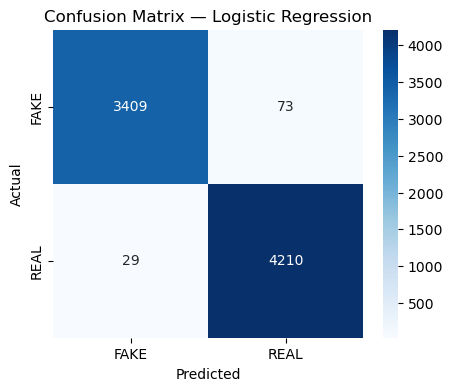

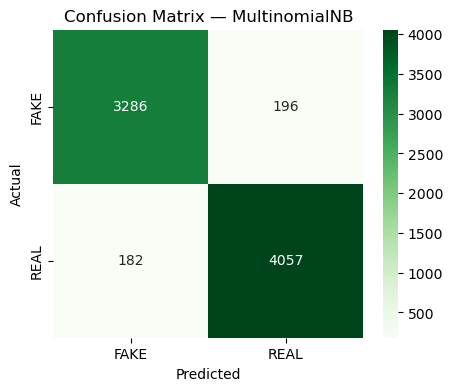

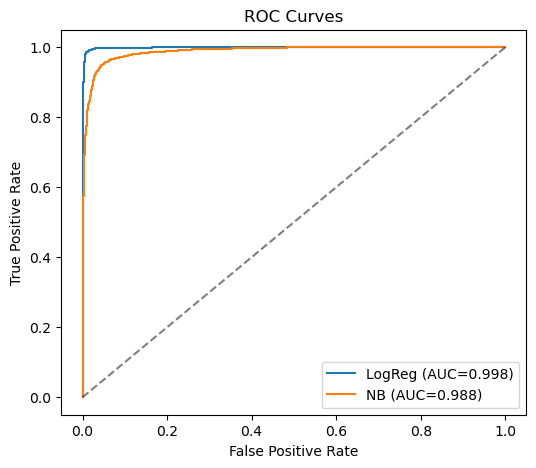

In [14]:
# Cell C: plot Confusion Matrix and ROC curves
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Logistic Regression CM
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(5,4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['FAKE','REAL'], yticklabels=['FAKE','REAL'])
plt.title("Confusion Matrix — Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# NB CM
cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(5,4))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Greens', xticklabels=['FAKE','REAL'], yticklabels=['FAKE','REAL'])
plt.title("Confusion Matrix — MultinomialNB")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_proba_nb)
auc_lr = auc(fpr_lr, tpr_lr)
auc_nb = auc(fpr_nb, tpr_nb)

plt.figure(figsize=(6,5))
plt.plot(fpr_lr, tpr_lr, label=f'LogReg (AUC={auc_lr:.3f})')
plt.plot(fpr_nb, tpr_nb, label=f'NB (AUC={auc_nb:.3f})')
plt.plot([0,1],[0,1],'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()


In [16]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=2000, class_weight='balanced')
lr.fit(X_train_tfidf, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,2000
,multi_class,'deprecated'


In [18]:
probs = lr.predict_proba(X_test_tfidf)[:,1]
threshold = 0.6   # tune: 0.5 -> default, raise to increase precision, lower to increase recall
y_pred_thresh = (probs >= threshold).astype(int)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_thresh, target_names=['FAKE','REAL']))


              precision    recall  f1-score   support

        FAKE       0.98      0.99      0.99      3482
        REAL       0.99      0.99      0.99      4239

    accuracy                           0.99      7721
   macro avg       0.99      0.99      0.99      7721
weighted avg       0.99      0.99      0.99      7721



In [20]:
proba_lr = lr.predict_proba(X_test_tfidf)[:,1]
proba_nb = nb.predict_proba(X_test_tfidf)[:,1]
proba_ens = (proba_lr + proba_nb) / 2
y_ens = (proba_ens >= 0.5).astype(int)
print(classification_report(y_test, y_ens, target_names=['FAKE','REAL']))


              precision    recall  f1-score   support

        FAKE       0.97      0.97      0.97      3482
        REAL       0.97      0.98      0.98      4239

    accuracy                           0.97      7721
   macro avg       0.97      0.97      0.97      7721
weighted avg       0.97      0.97      0.97      7721



In [22]:
from sklearn.feature_selection import chi2, SelectKBest
K = 5000
ch2 = SelectKBest(chi2, k=K).fit(X_train_tfidf, y_train)
X_train_sel = ch2.transform(X_train_tfidf)
X_test_sel  = ch2.transform(X_test_tfidf)
lr2 = LogisticRegression(max_iter=2000)
lr2.fit(X_train_sel, y_train)
print(classification_report(y_test, lr2.predict(X_test_sel)))


              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3482
           1       0.98      0.99      0.99      4239

    accuracy                           0.99      7721
   macro avg       0.99      0.99      0.99      7721
weighted avg       0.99      0.99      0.99      7721



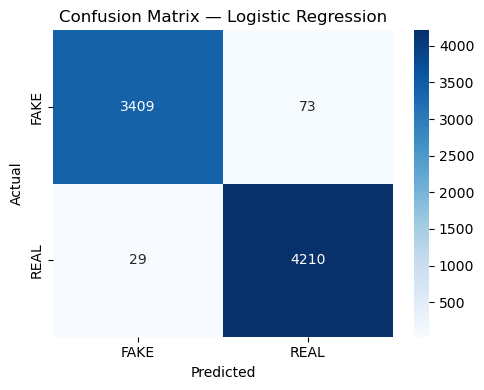

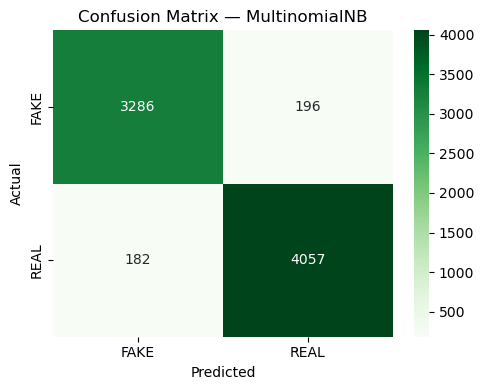

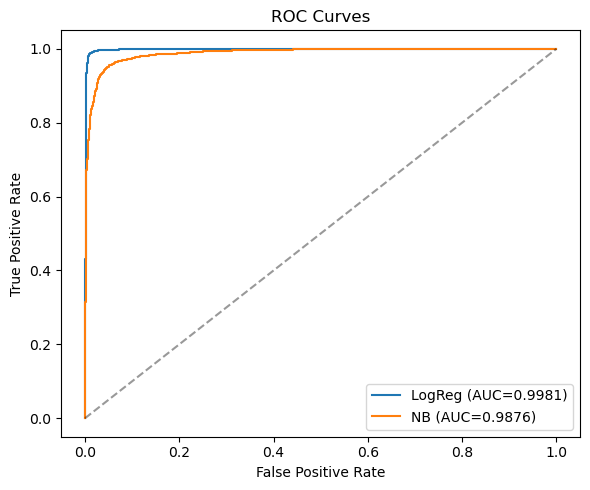

Top REAL indicators: reuters, say, washington reuters, reuter, washington, president donald, wednesday, tuesday, thursday, reuters president, republican, friday, monday, minister, nov, say statement, presidential, spokesman, democratic, london
Top FAKE indicators: via, image, read, feature image, gop, feature, we, mr, president trump, image via, hillary, us, even, america, go, obama, com, getty, get, like
Saved baseline_metrics.csv, confusion_lr.png, confusion_nb.png, roc_curves.png


In [24]:
# viz_and_metrics.py (run in notebook)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, classification_report

# ensure y_test, y_pred_lr, y_proba_lr, y_pred_nb, y_proba_nb exist
# Compute confusion matrices
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_nb = confusion_matrix(y_test, y_pred_nb)

# Save confusion matrices as images
plt.figure(figsize=(5,4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['FAKE','REAL'], yticklabels=['FAKE','REAL'])
plt.title("Confusion Matrix — Logistic Regression")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout(); plt.savefig("confusion_lr.png", dpi=200); plt.show()

plt.figure(figsize=(5,4))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Greens', xticklabels=['FAKE','REAL'], yticklabels=['FAKE','REAL'])
plt.title("Confusion Matrix — MultinomialNB")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout(); plt.savefig("confusion_nb.png", dpi=200); plt.show()

# ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_proba_nb)
auc_lr = auc(fpr_lr, tpr_lr)
auc_nb = auc(fpr_nb, tpr_nb)

plt.figure(figsize=(6,5))
plt.plot(fpr_lr, tpr_lr, label=f'LogReg (AUC={auc_lr:.4f})')
plt.plot(fpr_nb, tpr_nb, label=f'NB (AUC={auc_nb:.4f})')
plt.plot([0,1],[0,1],'k--', alpha=0.4)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curves'); plt.legend(); plt.tight_layout()
plt.savefig("roc_curves.png", dpi=200); plt.show()

# Top TF-IDF features (approx)
try:
    feat_names = np.array(vectorizer.get_feature_names_out())
    coefs = lr.coef_[0]
    top_pos = feat_names[np.argsort(coefs)[-20:]][::-1]
    top_neg = feat_names[np.argsort(coefs)[:20]]
    print("Top REAL indicators:", ", ".join(top_pos[:20]))
    print("Top FAKE indicators:", ", ".join(top_neg[:20]))
except Exception as e:
    print("Feature extraction error:", e)

# Save metrics CSV
metrics = {
    'model': ['LogisticRegression','MultinomialNB'],
    'accuracy': [accuracy_score(y_test, y_pred_lr), accuracy_score(y_test, y_pred_nb)],
    'precision_real': [precision_score(y_test, y_pred_lr), precision_score(y_test, y_pred_nb)],
    'recall_real': [recall_score(y_test, y_pred_lr), recall_score(y_test, y_pred_nb)],
    'f1_real': [f1_score(y_test, y_pred_lr), f1_score(y_test, y_pred_nb)],
    'roc_auc': [auc_lr, auc_nb]
}
pd.DataFrame(metrics).to_csv("baseline_metrics.csv", index=False)
print("Saved baseline_metrics.csv, confusion_lr.png, confusion_nb.png, roc_curves.png")
